# Teaching A MellowMax Deep Q Neural Network How To Balance
![A Balancing Act](https://i.imgur.com/UDO47Cl.gif)

# Reinforcement learning architecture
We are training a Deep-Q network without a target network using a mellowmax operator. The model is constructed and tuned with Bayesian hyperparameter optimization, which results in an optimized architecture using a small number of layers with Tanh and Mish activation functions.

>For any finite Markov decision process (FMDP), Q-learning finds a policy that is optimal in the sense that it maximizes the expected value of the total reward over any and all successive steps, starting from the current state. Q-learning can identify an optimal action-selection policy for any given FMDP, given infinite exploration time and a partly-random policy. "Q" names the function that returns the reward used to provide the reinforcement and can be said to stand for the "quality" of an action taken in a given state.

Source: https://en.wikipedia.org/wiki/Q-learning

![MellowMax Q Learning Algorithm](https://i.imgur.com/1q1HUX0.png)

The use of the mellowmax operator improves training performance, reduces the need for a target network, and speeds up learning. "This operator has been shown to ensure convergence in learning and planning, has an entropy-regularization interpretation, and facilitates convergent off-policy learning even with non-linear function approximation." "The use of Mellowmax in DQN mitigates the main cause of instability in online reinforcement learning with deep neural networks." (Ref: https://www.ijcai.org/proceedings/2019/0379.pdf)

>One of the important elements of DQN is its use of a target network, which is necessary to stabilize learning. We argue that using a target network is incompatible with online reinforcement learning, and it is possible to achieve faster and more stable learning without a target network when we use Mellowmax, an alternative softmax operator. We derive novel properties of Mellowmax, and empirically show that the combination of DQN and Mellowmax, but without a target network, outperforms DQN with a target network.

Source: https://www.researchgate.net/publication/334843577_DeepMellow_Removing_the_Need_for_a_Target_Network_in_Deep_Q-Learning

In [7]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Dependencies
import os
import math
from collections import deque
from chainer import functions as F
import skopt
import bottleneck as bn
import matplotlib.pyplot as plt

In [8]:
def learn_to_balance(model_layers=3,
                     model_layer_size=34,
                     model_layer_taper=1.0490184900205404,
                     model_activation_1=2,
                     model_activation_2=2,
                     model_activation_3=1,
                     mm_omega=3.3475360424700393,
                     batch_size=113,
                     memory_size=10000,
                     discount_factor=0.9725879085561605,
                     epsilon=0.9985988622823487,
                     epsilon_decay=0.9469565368958073,
                     lr=0.000584644333009868,
                     epsilon_min=0.01,
                     train_start=256,
                     n_episodes=500,
                     n_win_ticks=195,
                     n_avg_scores=100,
                     n_max_steps=200,
                     logging_int=10,
                     verbose=False,
                     render=False,
                     return_history=False,
                     win_100_scalar=1.1, # Optimizer bonus for a fast win < 100 episodes
                     win_10_scalar=1.15, # Optimizer bonus for a fast win < 10 episodes
                     seed=123):

  # Environment
  import gym
  env = gym.make('CartPole-v0')
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n

  # Reproducibility
  os.environ['PYTHONHASHSEED'] = str(seed)
  import random
  import numpy as np
  env.seed(seed)
  env.action_space.seed(seed)
  random.seed(seed)
  np.random.seed(seed)

  # Apply seed to tensorflow session
  import tensorflow as tf
  import keras.backend as K
  from keras.utils.generic_utils import get_custom_objects
  from keras.layers import Dense, Activation
  from keras.models import Sequential
  from keras.optimizers import Adam
  tf.reset_default_graph()
  session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  tf.set_random_seed(seed)
  sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
  K.set_session(sess)

  # Mish Activation implementation
  # Source: https://github.com/digantamisra98/Mish/blob/master/Mish/Keras/mish.py
  class Mish(Activation):
    def __init__(self, activation="Mish", **kwargs):
      super(Mish, self).__init__(activation, **kwargs)
      self.__name__ = 'Mish'

  def mish(x):
    return x*K.tanh(K.softplus(x))

  get_custom_objects().update({'Mish': Mish(mish)})

  # Mellowmax: Softmax alternative
  # See: http://arxiv.org/abs/1612.05628
  # Source: https://github.com/chainer/chainerrl/blob/master/chainerrl/functions/mellowmax.py
  def mellowmax(values, omega=1., axis=1):
    n = values.shape[axis]
    return (F.logsumexp(omega * values, axis=axis) - np.log(n)) / omega

  # Build model
  def build_model(state_size, action_size, model_layers=3, model_activation_1=2, model_activation_2=2, model_activation_3=2, model_layer_size=96, model_layer_taper=0.5, lr=0.003):
    model = Sequential()

    model.add(Dense(int(model_layer_size), input_dim=state_size, kernel_initializer='he_uniform'))

    for i in range(int(model_layers)):
      layer_size = min(16, int(model_layer_size * (model_layer_taper ** i)))
      model.add(Dense(layer_size, kernel_initializer='he_uniform'))
      if i % 3 == 0:
        model_activation = model_activation_3
      elif i % 2 == 0:
        model_activation = model_activation_2
      else:
        model_activation = model_activation_1
    
      if round(model_activation) == 0:
        model.add(Activation('relu'))
      elif round(model_activation) == 1:
        model.add(Activation('tanh'))
      else:
        model.add(Mish())
    model.add(Dense(action_size, kernel_initializer='he_uniform'))
    model.compile(Adam(lr=lr), loss='mse')
    return model

  # Training
  # Source: https://github.com/yanpanlau/CartPole/blob/master/DQN/CartPole_DQN.py
  def get_action(state, action_size, model, epsilon):
    return np.random.randint(action_size) if np.random.rand() <= epsilon else np.argmax(model.predict(state)[0])

  def train_replay(memory, batch_size, train_start, discount_factor, mm_omega, model):
    if len(memory) < train_start:
      return
    minibatch = random.sample(memory,  min(int(batch_size), len(memory)))

    # Experience replay
    state_t, action_t, reward_t, state_t1, terminal = zip(*minibatch)
    state_t = np.concatenate(state_t)
    state_t1 = np.concatenate(state_t1)
    targets = model.predict(state_t)
    Q_sa = model.predict(state_t1)
    mm = mellowmax(Q_sa, omega=mm_omega).data

    targets[range(int(batch_size)), action_t] = reward_t + discount_factor * mm * np.invert(terminal)
    model.train_on_batch(state_t, targets)

  # Model
  model = build_model(state_size, action_size,
                      model_layers=model_layers, model_layer_size=model_layer_size,
                      model_layer_taper=model_layer_taper, lr=lr)

  # Training
  solution = []
  all_scores = []
  scores = deque(maxlen=int(n_avg_scores))
  memory = deque(maxlen=int(memory_size))
  solution_window_start = n_episodes

  for e in range(n_episodes):
    done = False
    score = 0
    step = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    while not done and step < n_max_steps:
      action = get_action(state, action_size, model, epsilon)
      next_state, reward, done, info = env.step(action)
      next_state = np.reshape(next_state, [1, state_size])

      memory.append(
          (state, action, reward if not done else -100, next_state, done))
      if epsilon > epsilon_min:
        epsilon *= epsilon_decay  # Decrease randomness
      train_replay(memory, batch_size, train_start, discount_factor, mm_omega, model)
      score += reward
      step += 1
      state = next_state

      if render:
        env.render()

      if done:
        env.reset()
        scores.append(score)
        all_scores.append(score)
        avg_score = np.mean(scores)

        if len(solution) == 0 and avg_score >= n_win_ticks and e >= n_avg_scores:
          # The start of a 100-episode averaging window with a mean score >= 195
          solution_window_start = e - n_avg_scores

          # The first episode score >= 195
          solution_episode_idx = next(
              x[0] for x in enumerate(all_scores) if x[1] >= n_win_ticks)

          solution.append(solution_window_start)
          print('Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode {} \o/'.format(
              solution_window_start))
          print('First score >= 195 reached at episode {}.'.format(
              solution_episode_idx))

        if verbose > 0 and e % logging_int == 0:
          avg_display = '{:.2f}'.format(avg_score)
          print('[Episode {}] Average Score: {} | Total Rewards: {:.2f}'.format(
              e, avg_display, score))
  return solution_window_start, np.mean(all_scores), all_scores

def run_game(**config):
  solution_window_start, avg_score, all_scores = learn_to_balance(**config)
  if 'return_history' in config and config['return_history']:
        return solution_window_start, avg_score, all_scores
  if solution_window_start < 10:
    return avg_score * config['win_10_scalar']
  elif solution_window_start < 100:
    return avg_score * config['win_100_scalar']
  return avg_score

## Hyperparameter Tuning
>The model parameters are optimized using gradient boosted trees. Gradient boosted regression trees are used to model the (very) expensive to evaluate function `func`. The model is improved by sequentially evaluating the expensive function at the next best point. Thereby finding the minimum of `func` with as few evaluations as possible.

Source: https://scikit-optimize.github.io/

In [12]:
# Bounded region of parameter space
SPACE = [skopt.space.Real(0.0005, 0.01, name='lr', prior='uniform'),
         skopt.space.Real(0.9, 1.0, name='discount_factor', prior='uniform'),
         skopt.space.Real(0.9, 0.99, name='epsilon_decay', prior='uniform'),
         skopt.space.Real(0.9, 1.0, name='epsilon', prior='uniform'),
         skopt.space.Real(1.0, 30.0, name='mm_omega', prior='uniform'),
         skopt.space.Real(0.5, 1.5, name='model_layer_taper', prior='uniform'),
         skopt.space.Integer(16, 128, name='model_layer_size'),
         skopt.space.Integer(0, 2, name='model_activation_1'),
         skopt.space.Integer(0, 2, name='model_activation_2'),
         skopt.space.Integer(0, 2, name='model_activation_3'),
         skopt.space.Integer(32, 128, name='batch_size'),
         skopt.space.Integer(3, 5, name='model_layers')]

@skopt.utils.use_named_args(SPACE)
def objective(**params):
    return -1.0 * run_game(**params, win_100_scalar=1.1, win_10_scalar=1.2)

print('Searching parameter space... Now would be a good time to make coffee. ☕')

results = skopt.gbrt_minimize(objective, SPACE, n_calls=500, callback=[skopt.callbacks.VerboseCallback(n_total=500)], random_state=123)
print(results)

Searching parameter space... Now would be a good time to make coffee. ☕
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 118.5954
Function value obtained: -52.7940
Current minimum: -52.7940
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 266.4835
Function value obtained: -102.5100
Current minimum: -102.5100
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 280.8947
Function value obtained: -115.8380
Current minimum: -115.8380
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 236.1114
Function value obtained: -98.5480
Current minimum: -115.8380
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 410.8176
Function value obtained: -171.8380
Current minimum: -171.8380
Iteration No: 40 started. Searching for the next optimal point.
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 353.6520
Function value obtained: -134.9280
Current minimum: -171.8380
Iteration No: 41 started. Searching for the next optimal point.
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 168 \o/
First score >= 195 reached at episode 30.
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 292.4566
Function value obtained: -166.8920
Current minimum: -171.8380
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 353.4849
Function value obtained: -167.9980
Current minimum: -171.8380
Iteration No: 43 started. Searching for the next optimal point.
Solved! Avg. r

Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 245 \o/
First score >= 195 reached at episode 27.
Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 428.9243
Function value obtained: -170.5000
Current minimum: -221.1888
Iteration No: 75 started. Searching for the next optimal point.
Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 215.6891
Function value obtained: -120.4500
Current minimum: -221.1888
Iteration No: 76 started. Searching for the next optimal point.
Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 315.2291
Function value obtained: -127.6400
Current minimum: -221.1888
Iteration No: 77 started. Searching for the next optimal point.
Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 295.3186
Function value obtained: -161.6060
Current minimum: -221.1888
Iteration No: 78 started. Searching for the next optimal point.
Iteration No: 

Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 285.7302
Function value obtained: -156.5140
Current minimum: -221.1888
Iteration No: 108 started. Searching for the next optimal point.
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 286.7662
Function value obtained: -104.9660
Current minimum: -221.1888
Iteration No: 109 started. Searching for the next optimal point.
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 201 \o/
First score >= 195 reached at episode 44.
Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 424.8707
Function value obtained: -164.7640
Current minimum: -221.1888
Iteration No: 110 started. Searching for the next optimal point.
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 114.6225
Function value obtained: -45.4800
Current minimum: -221.1888
Iteration No: 111 started. Searching for the next optimal point.
Iterati

Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 258.7360
Function value obtained: -148.0980
Current minimum: -221.1888
Iteration No: 141 started. Searching for the next optimal point.
Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 202.7373
Function value obtained: -90.5060
Current minimum: -221.1888
Iteration No: 142 started. Searching for the next optimal point.
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 22 \o/
First score >= 195 reached at episode 14.
Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 276.1462
Function value obtained: -181.3086
Current minimum: -221.1888
Iteration No: 143 started. Searching for the next optimal point.
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 390 \o/
First score >= 195 reached at episode 46.
Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 434.8974
Function 

Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 397.7976
Function value obtained: -162.6800
Current minimum: -221.1888
Iteration No: 175 started. Searching for the next optimal point.
Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 388.8222
Function value obtained: -153.3740
Current minimum: -221.1888
Iteration No: 176 started. Searching for the next optimal point.
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 350 \o/
First score >= 195 reached at episode 35.
Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 394.9146
Function value obtained: -153.4640
Current minimum: -221.1888
Iteration No: 177 started. Searching for the next optimal point.
Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 205.5240
Function value obtained: -90.4040
Current minimum: -221.1888
Iteration No: 178 started. Searching for the next optimal point.
Iterati

Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 45 \o/
First score >= 195 reached at episode 49.
Iteration No: 208 ended. Search finished for the next optimal point.
Time taken: 305.4921
Function value obtained: -159.9818
Current minimum: -221.1888
Iteration No: 209 started. Searching for the next optimal point.
Iteration No: 209 ended. Search finished for the next optimal point.
Time taken: 339.0009
Function value obtained: -156.1300
Current minimum: -221.1888
Iteration No: 210 started. Searching for the next optimal point.
Iteration No: 210 ended. Search finished for the next optimal point.
Time taken: 65.8126
Function value obtained: -28.3080
Current minimum: -221.1888
Iteration No: 211 started. Searching for the next optimal point.
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 93 \o/
First score >= 195 reached at episode 13.
Iteration No: 211 ended. Search finished for the next optimal point.
Time taken: 439.5546
Function va

Iteration No: 243 ended. Search finished for the next optimal point.
Time taken: 198.2965
Function value obtained: -107.9420
Current minimum: -221.1888
Iteration No: 244 started. Searching for the next optimal point.
Iteration No: 244 ended. Search finished for the next optimal point.
Time taken: 204.5623
Function value obtained: -78.1040
Current minimum: -221.1888
Iteration No: 245 started. Searching for the next optimal point.
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 365 \o/
First score >= 195 reached at episode 22.
Iteration No: 245 ended. Search finished for the next optimal point.
Time taken: 399.0911
Function value obtained: -167.7940
Current minimum: -221.1888
Iteration No: 246 started. Searching for the next optimal point.
Iteration No: 246 ended. Search finished for the next optimal point.
Time taken: 398.6493
Function value obtained: -161.4900
Current minimum: -221.1888
Iteration No: 247 started. Searching for the next optimal point.
Iterati

Iteration No: 277 ended. Search finished for the next optimal point.
Time taken: 244.9563
Function value obtained: -147.6680
Current minimum: -221.1888
Iteration No: 278 started. Searching for the next optimal point.
Iteration No: 278 ended. Search finished for the next optimal point.
Time taken: 312.6662
Function value obtained: -123.9800
Current minimum: -221.1888
Iteration No: 279 started. Searching for the next optimal point.
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 98 \o/
First score >= 195 reached at episode 28.
Iteration No: 279 ended. Search finished for the next optimal point.
Time taken: 292.9673
Function value obtained: -179.6366
Current minimum: -221.1888
Iteration No: 280 started. Searching for the next optimal point.
Iteration No: 280 ended. Search finished for the next optimal point.
Time taken: 304.4112
Function value obtained: -160.0960
Current minimum: -221.1888
Iteration No: 281 started. Searching for the next optimal point.
Iterati

Iteration No: 311 ended. Search finished for the next optimal point.
Time taken: 84.3425
Function value obtained: -37.6700
Current minimum: -221.1888
Iteration No: 312 started. Searching for the next optimal point.
Iteration No: 312 ended. Search finished for the next optimal point.
Time taken: 267.1070
Function value obtained: -99.6960
Current minimum: -221.1888
Iteration No: 313 started. Searching for the next optimal point.
Iteration No: 313 ended. Search finished for the next optimal point.
Time taken: 362.3851
Function value obtained: -143.5540
Current minimum: -221.1888
Iteration No: 314 started. Searching for the next optimal point.
Iteration No: 314 ended. Search finished for the next optimal point.
Time taken: 391.3964
Function value obtained: -149.4480
Current minimum: -221.1888
Iteration No: 315 started. Searching for the next optimal point.
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 129 \o/
First score >= 195 reached at episode 47.
Iteration

Iteration No: 345 ended. Search finished for the next optimal point.
Time taken: 292.8091
Function value obtained: -169.5980
Current minimum: -221.1888
Iteration No: 346 started. Searching for the next optimal point.
Iteration No: 346 ended. Search finished for the next optimal point.
Time taken: 378.2529
Function value obtained: -140.5740
Current minimum: -221.1888
Iteration No: 347 started. Searching for the next optimal point.
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 107 \o/
First score >= 195 reached at episode 45.
Iteration No: 347 ended. Search finished for the next optimal point.
Time taken: 349.2095
Function value obtained: -165.1140
Current minimum: -221.1888
Iteration No: 348 started. Searching for the next optimal point.
Iteration No: 348 ended. Search finished for the next optimal point.
Time taken: 287.3473
Function value obtained: -157.1580
Current minimum: -221.1888
Iteration No: 349 started. Searching for the next optimal point.
Iterat

Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 228 \o/
First score >= 195 reached at episode 22.
Iteration No: 379 ended. Search finished for the next optimal point.
Time taken: 283.9974
Function value obtained: -124.6460
Current minimum: -221.1888
Iteration No: 380 started. Searching for the next optimal point.
Iteration No: 380 ended. Search finished for the next optimal point.
Time taken: 309.1830
Function value obtained: -146.6440
Current minimum: -221.1888
Iteration No: 381 started. Searching for the next optimal point.
Iteration No: 381 ended. Search finished for the next optimal point.
Time taken: 260.5006
Function value obtained: -123.5020
Current minimum: -221.1888
Iteration No: 382 started. Searching for the next optimal point.
Iteration No: 382 ended. Search finished for the next optimal point.
Time taken: 321.8598
Function value obtained: -146.9000
Current minimum: -221.1888
Iteration No: 383 started. Searching for the next optimal point.
Solved

Iteration No: 414 ended. Search finished for the next optimal point.
Time taken: 256.8617
Function value obtained: -166.8150
Current minimum: -221.1888
Iteration No: 415 started. Searching for the next optimal point.
Iteration No: 415 ended. Search finished for the next optimal point.
Time taken: 98.4541
Function value obtained: -46.2680
Current minimum: -221.1888
Iteration No: 416 started. Searching for the next optimal point.
Iteration No: 416 ended. Search finished for the next optimal point.
Time taken: 50.9072
Function value obtained: -35.2880
Current minimum: -221.1888
Iteration No: 417 started. Searching for the next optimal point.
Iteration No: 417 ended. Search finished for the next optimal point.
Time taken: 143.5024
Function value obtained: -65.6860
Current minimum: -221.1888
Iteration No: 418 started. Searching for the next optimal point.
Iteration No: 418 ended. Search finished for the next optimal point.
Time taken: 422.3162
Function value obtained: -162.6700
Current mini

Iteration No: 448 ended. Search finished for the next optimal point.
Time taken: 290.7124
Function value obtained: -170.7900
Current minimum: -221.1888
Iteration No: 449 started. Searching for the next optimal point.
Iteration No: 449 ended. Search finished for the next optimal point.
Time taken: 232.1297
Function value obtained: -138.8840
Current minimum: -221.1888
Iteration No: 450 started. Searching for the next optimal point.
Iteration No: 450 ended. Search finished for the next optimal point.
Time taken: 150.4464
Function value obtained: -67.4900
Current minimum: -221.1888
Iteration No: 451 started. Searching for the next optimal point.
Iteration No: 451 ended. Search finished for the next optimal point.
Time taken: 253.9122
Function value obtained: -133.9180
Current minimum: -221.1888
Iteration No: 452 started. Searching for the next optimal point.
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 10 \o/
First score >= 195 reached at episode 13.
Iteratio

Iteration No: 482 ended. Search finished for the next optimal point.
Time taken: 187.1174
Function value obtained: -107.8580
Current minimum: -221.1888
Iteration No: 483 started. Searching for the next optimal point.
Iteration No: 483 ended. Search finished for the next optimal point.
Time taken: 291.5957
Function value obtained: -172.1400
Current minimum: -221.1888
Iteration No: 484 started. Searching for the next optimal point.
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 355 \o/
First score >= 195 reached at episode 17.
Iteration No: 484 ended. Search finished for the next optimal point.
Time taken: 272.2121
Function value obtained: -158.4480
Current minimum: -221.1888
Iteration No: 485 started. Searching for the next optimal point.
Iteration No: 485 ended. Search finished for the next optimal point.
Time taken: 132.4500
Function value obtained: -78.0260
Current minimum: -221.1888
Iteration No: 486 started. Searching for the next optimal point.
Iterati

In [9]:
# Environment seed hyperparameter optimization

best_solution_window_start = 200
best_avg_score = 0
best_all_scores = []

for seed in range(500):
    solution_window_start, avg_score, all_scores = run_game(seed=seed, n_episodes=200, return_history=True)
    if solution_window_start < best_solution_window_start:
        best_solution_window_start = solution_window_start
        best_avg_score = avg_score
        best_all_scores = all_scores
        print('Optimal seed found! Seed {} - Solved at episode: {}'.format(seed, solution_window_start))
    else:
        print('Seed {} - Stopped at episode: {}'.format(seed, solution_window_start))

Seed 0 - Stopped at episode: 200
Seed 1 - Stopped at episode: 200
Seed 2 - Stopped at episode: 200
Seed 3 - Stopped at episode: 200
Seed 4 - Stopped at episode: 200
Seed 5 - Stopped at episode: 200
Seed 6 - Stopped at episode: 200
Seed 7 - Stopped at episode: 200
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 13 \o/
First score >= 195 reached at episode 1.
Optimal seed found! Seed 8 - Solved at episode: 13
Seed 9 - Stopped at episode: 200
Seed 10 - Stopped at episode: 200
Seed 11 - Stopped at episode: 200
Seed 12 - Stopped at episode: 200
Seed 13 - Stopped at episode: 200
Seed 14 - Stopped at episode: 200
Seed 15 - Stopped at episode: 200
Seed 16 - Stopped at episode: 200
Seed 17 - Stopped at episode: 200
Seed 18 - Stopped at episode: 200
Seed 19 - Stopped at episode: 200
Seed 20 - Stopped at episode: 200
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 79 \o/
First score >= 195 reached at episode 11.
Seed 21 - Stopped at episode:

Seed 138 - Stopped at episode: 62
Seed 139 - Stopped at episode: 200
Seed 140 - Stopped at episode: 200
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 28 \o/
First score >= 195 reached at episode 30.
Seed 141 - Stopped at episode: 28
Seed 142 - Stopped at episode: 200
Seed 143 - Stopped at episode: 200
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 51 \o/
First score >= 195 reached at episode 25.
Seed 144 - Stopped at episode: 51
Seed 145 - Stopped at episode: 200
Seed 146 - Stopped at episode: 200
Seed 147 - Stopped at episode: 200
Seed 148 - Stopped at episode: 200
Seed 149 - Stopped at episode: 200
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 45 \o/
First score >= 195 reached at episode 25.
Seed 150 - Stopped at episode: 45
Seed 151 - Stopped at episode: 200
Seed 152 - Stopped at episode: 200
Seed 153 - Stopped at episode: 200
Seed 154 - Stopped at episode: 200
Seed 155 - Stopped at episode: 200

Seed 288 - Stopped at episode: 200
Seed 289 - Stopped at episode: 200
Seed 290 - Stopped at episode: 200
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 27 \o/
First score >= 195 reached at episode 29.
Seed 291 - Stopped at episode: 27
Seed 292 - Stopped at episode: 200
Seed 293 - Stopped at episode: 200
Seed 294 - Stopped at episode: 200
Seed 295 - Stopped at episode: 200
Seed 296 - Stopped at episode: 200
Seed 297 - Stopped at episode: 200
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 44 \o/
First score >= 195 reached at episode 1.
Seed 298 - Stopped at episode: 44
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 35 \o/
First score >= 195 reached at episode 32.
Seed 299 - Stopped at episode: 35
Seed 300 - Stopped at episode: 200
Seed 301 - Stopped at episode: 200
Seed 302 - Stopped at episode: 200
Seed 303 - Stopped at episode: 200
Seed 304 - Stopped at episode: 200
Seed 305 - Stopped at episode: 200

Seed 435 - Stopped at episode: 35
Seed 436 - Stopped at episode: 200
Seed 437 - Stopped at episode: 200
Seed 438 - Stopped at episode: 200
Seed 439 - Stopped at episode: 200
Seed 440 - Stopped at episode: 200
Seed 441 - Stopped at episode: 200
Seed 442 - Stopped at episode: 200
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 33 \o/
First score >= 195 reached at episode 17.
Seed 443 - Stopped at episode: 33
Seed 444 - Stopped at episode: 200
Seed 445 - Stopped at episode: 200
Seed 446 - Stopped at episode: 200
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 25 \o/
First score >= 195 reached at episode 27.
Seed 447 - Stopped at episode: 25
Seed 448 - Stopped at episode: 200
Solved! Avg. reward >= 195.0 over 100 consecutive trials reached at episode 85 \o/
First score >= 195 reached at episode 21.
Seed 449 - Stopped at episode: 85
Seed 450 - Stopped at episode: 200
Seed 451 - Stopped at episode: 200
Seed 452 - Stopped at episode: 200

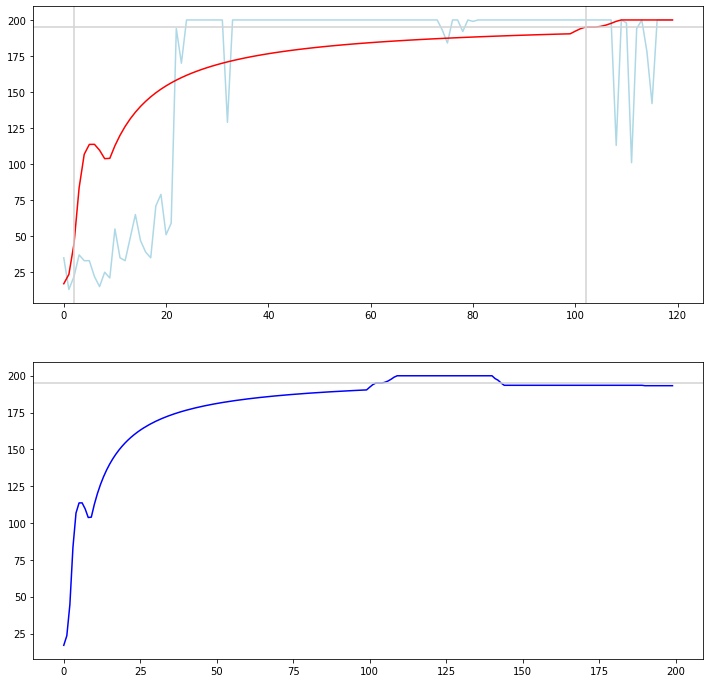

CartPoleV0 Solved at episode: 2


In [10]:
# Performance
rm_100 = bn.move_mean(best_all_scores, window=100, min_count=1)

fig, ax = plt.subplots(2, figsize=(12,12))
ax[0].plot(all_scores[:120], color='lightblue')
ax[0].plot(rm_100[:120], color='red')
ax[0].axvline(x=best_solution_window_start, color='lightgrey')
ax[0].axvline(x=best_solution_window_start + 100, color='lightgrey')
ax[0].axhline(y=195, color='lightgrey')
ax[1].plot(rm_100, color='blue')
ax[1].axhline(y=195, color='lightgrey')
plt.show()

print('CartPoleV0 Solved at episode: {}'.format(best_solution_window_start))